# Laboratorio 4 Redes Neuronales 
## Elements of Machine Learning 
## José Alejandro Guzmán Zamora

In [218]:
"""
Librerías a utilizar en el laboratorio. La primera es el archivo que
contiene la implementación de redes neuronales, en las celdas de abajo
lo copié al archivo actual con la intención de hacer debugging directo 
sin tener que reiniciar el kernel con cada cambio realizado. 
"""

import neural_net
import pandas as pd 
import pickle 
import numpy as np
import scipy.optimize as op
import time
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [2]:
"""
Previamente cloné el repositorio de fashion-mnist y convenientemente 
este tiene un módulo para hacer la lectura del dataset, a continuación
obtengo esas herramientas. 
"""

import sys
sys.path.insert(1, '../../fashion-mnist/utils')

import mnist_reader

In [3]:
"""
Lectura del dataset, de una vez se divide en train y test para realizar 
cross validation. 
"""

x_train, y_train = mnist_reader.load_mnist('../../fmnist', kind='train')
x_test, y_test = mnist_reader.load_mnist('../../fmnist', kind='t10k')

In [219]:
"""
Tal como mencioné al inicio, pegué mi implementación de redes neuronales aquí 
para agilizar mi flujo de desarrollo. Sin embargo lo que fue cambiando fue la 
manera en que inicializo los pesos. Por lo tanto, se puede consumir desde el 
archivo neural_net.py en este mismo directorio. 
"""

import numpy as np 
import copy 

def sigmoid(values):
    return 1 / (1 + np.exp(-values))

def forward_setup(nodos,X,Y,hidden_layers):
    nodos.insert(0,X.shape[1])
    nodos.append(len(Y[0]))
    nodes = [i + 1 for i in nodos]

    # red, mesh de thetas 
    thetas = []
    # por el momento le voy a poner mas 1 por la output layer 
    for i in range(hidden_layers + 1):
        temp_primero = np.expand_dims(np.asarray([(np.random.randn() / 5) for i in range(nodes[i])],dtype='float64'),1)
        thetas.append(np.matrix(np.asarray(
            [temp_primero for i in range(nodos[i + 1])]
            )))
    return thetas

def forward_prop(X,thetas):
    inicial = X.T      
    trace = [inicial]
    for i in range(len(thetas)):
        interno = np.matmul(
            thetas[i],
            np.vstack(
                [np.expand_dims(np.ones(trace[i].shape[1]),0),
                trace[i]]
                )
        )
        trace.append(sigmoid(interno))
    return trace 

def backward_prop(thetas,shapes,X,Y):
    m,_ = X.shape
    # regresar a su normalidad 
    thetas = unflatten_zetas(thetas,shapes)
    delta = copy.deepcopy(thetas)
    for i in delta: i[:] = 0
    activation_trace = forward_prop(X,thetas)
    first_delta = activation_trace[-1] - Y.T
    deltas = [first_delta]
    # backward prop 
    for i in reversed(range(1,len(thetas))):
        first_delta = np.multiply(
            np.matmul(thetas[i].T[1:,:],first_delta),
            np.multiply(activation_trace[i],(1-activation_trace[i]))
            )
        deltas.append(first_delta)
    deltas.append(None)

    deltas = list(reversed(deltas))
    for i in range(len(delta)):
        temp_shape = activation_trace[i].shape
        multi_res = np.matmul(
            deltas[i + 1],
            np.vstack([np.ones((1,temp_shape[1])),activation_trace[i]]).T
            )
        delta[i] += multi_res / m
    return flatten_zetas(delta)[0]
    
def flatten_zetas(thetas):
    flat_zetas = np.asarray([])
    shapes = []
    for i in thetas:
        shapes.append(i.shape)
        flat_zetas = np.concatenate((flat_zetas,np.ravel(i)))
    return (flat_zetas,shapes)

def unflatten_zetas(flat_thetas,shapes):
    res = []
    for i in shapes:
        cantidad = i[0] * i[1]  
        res.append(flat_thetas[:cantidad].reshape(i))
    return res 

def cost(thetas,shapes,X,Y):
    thetas = unflatten_zetas(thetas,shapes)
    h = forward_prop(X,thetas)[-1]
    calculate = (Y * np.log(h).T) + ((1 - Y) * np.log(1 - h).T)
    print(np.sum(calculate) / (- X.shape[0]))
    return np.sum(calculate) / (- X.shape[0])

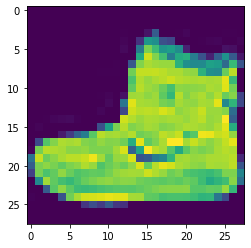

9


In [220]:
"""
Verificación de las imágenes para darse una idea de lo que se está trabajando. 
En esta celda también se hace una división sobre los valores del dataset para 
no caer en gradient explosion. Si estos valores son muy grandes, el resultado 
del sigmoide por lo general es 1 y la función de costo se va al infinito. 
Además se separan los labels en arreglos de 0s y 1s para ingresarlos a la red. 
"""

verificacion = plt.imshow(x_train[0].reshape(28,28))
plt.show()
print(y_train[0])
x_train_ingreso = x_train / 1000
x_test_ingreso = x_test / 1000
categorias = 10
y_train_ingreso = (np.expand_dims(y_train,1) == np.arange(categorias)).astype(int)
y_test_ingreso = (np.expand_dims(y_test,1) == np.arange(categorias)).astype(int)

In [184]:
"""
Definición de la arquitectura. Ya sabemos que tendremos 784 inputs 
y utilicé una hidden layer con 2000 neuronas. Además se inicializan 
los thetas y se transforman a un vector plano para la optimización. 
"""

architecture = [2000]
thetas = forward_setup(architecture,x_train_ingreso, y_train_ingreso, len(architecture))
flat_thetas = flatten_zetas(thetas)

# Entrenamiento 

In [185]:
"""
Entrenamiento del modelo, se utilizó el algoritmo de minimize 
de scipy con el método L-BFGS-B para hace el entrenamiento. Lo 
que mando a imprimir es un trace de cómo se fueron comportando 
los pesos conforme el tiempo. 
"""

start = time.time()

res = op.minimize(
    fun=cost,
    x0=flat_thetas[0],
    args=(flat_thetas[1],x_train_ingreso,y_train_ingreso),
    method='L-BFGS-B',
    jac=backward_prop,
    options={
        'disp':True,
        'maxiter':1300
    }
)

end = time.time()

39.71615639057327
35.659719180356156
20.95064059610047
11.204083127597464
9.171584116800869
6.448289414262405
38.04249577165899
12.607031594114497
6.143846607714409
5.528831764493346
6.68393552693459
4.9640206749459335
5.394488403853958
4.7703782670219095
11.482828161811774
4.896151975138058
4.342388919763659
4.685900290261928
3.955515120354737
3.8182398431133993
2.886409450690918
2.442182635453975
2.0366420996690184
6.875999576246029
2.356457668619646
2.040778089565356
2.032593468586256
2.034233279578073
2.0316642687192084
2.0323384459523566
2.0314688163149364
2.0316072362792554
2.0316642687192084
2.0558443177967884
1.750997641755969
5.530645507029404
2.390631807570443
1.7350564071365167
3.7466082853171083
1.896867921514932
1.7497379585203177
1.7371718142104358
1.7354569393691333
1.735138643452056
1.7350736081273372
1.7350600193298935
1.7350571663312615
1.735056566728886
1.735056440686104
1.7350564141893827
1.7350564086191875
1.735056407448207
1.7350564072020407
1.7350564071502912
1.7

d:\cs7\env\lib\site-packages\ipykernel_launcher.py:83: RuntimeWarning: divide by zero encountered in log
d:\cs7\env\lib\site-packages\ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in multiply


nan
nan


d:\cs7\env\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in exp
  


nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
1.4377256567918768
1.3824495738727993
1.3755385803160693
1.3604750622651212
1.3550473337513862
1.3017271477641028
1.276684811687214
1.2645892816270268
2.8169541076595985
1.2801817767563353
1.265961177581101
1.2647978459151907
1.2646296106914836
1.264597607586664
1.264591025938893
1.2645896482108665
1.2645893587190173
1.2645892978416018
1.2645892850374991
1.2645892823443692
1.2645892817779092
1.2645892816587625
1.2645892816337019
1.2645892816284312
1.2645892816273225
1.2645892816270892
1.2645892816270403
1.2645892816270303
1.339385319116542
1.2201778827674081
1.2105658694150896
1.2070753166203283
1.203357534400441
1.1976644190518253
1.2189110081212287
1.1961978254515935
1.1963292645559325
1.1961136346529977
1.196086825271167
1.196091555647005
1.196086825271167
1.2034428826405128
1.189323997656338
1.182967590174585
1.1691851382649665
1.3593397498479776
1.1618425317868926
1.1645061181092302
1.161717469554848
1.1618646

In [197]:
"""
Se puede ver que tardó 9667 segundos en entrenar, esto es equivalente a 
2.7 horas aproximadamente. El algoritmo hizo un total de 117 iteraciones 
hasta considerar la convergencia. 
"""

print("Tiempo en segundos: ",end-start)
res

9667.402080535889


      fun: 0.8787728362518883
 hess_inv: <1590010x1590010 LbfgsInvHessProduct with dtype=float64>
      jac: array([-6.43357950e-05,  8.01113514e-09, -6.12798832e-08, ...,
       -4.62840906e-04, -4.75298693e-04, -4.17584584e-04])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 619
      nit: 117
   status: 0
  success: True
        x: array([-0.21348842,  0.48722762, -0.07573743, ..., -1.19284948,
       -1.66644739, -1.06440122])

In [187]:
"""
Guardar el modelo. 
"""

with open('model.txt', 'wb') as f:
    pickle.dump(res, f)

In [188]:
"""
Comenzar con la evaluación, se aplanan los pesos finales 
y se ingresan los datos de test a forward prop para los 
intentos de clasificación. 
"""

new_thetas = unflatten_zetas(res.x,flat_thetas[1])
respuestas = forward_prop(x_test_ingreso,new_thetas)

In [191]:
y_pred = np.asarray([np.argmax(i) for i in respuestas[-1].T])

In [192]:
"""
Evaluación formal por medio de accuracy, es decir, la cantidad 
de clasificaciones correctas dividido la cantidad total de registros. 
Se logró un accuracy del 83% 
"""

from sklearn import metrics 

metrics.accuracy_score(y_test,y_pred)

0.8292

Sneaker


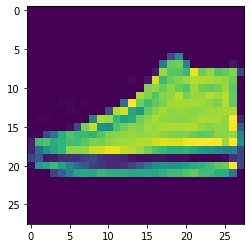

Sneaker


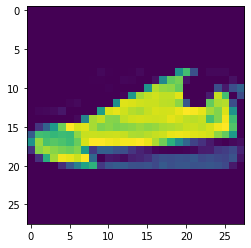

Bag


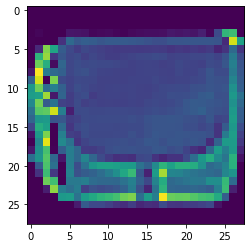

Sandal


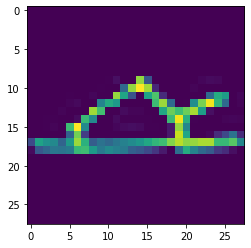

Trouser


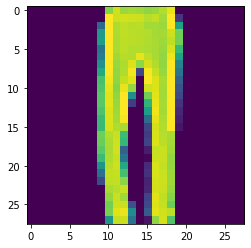

Bag


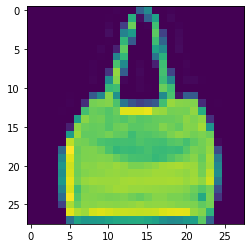

Sandal


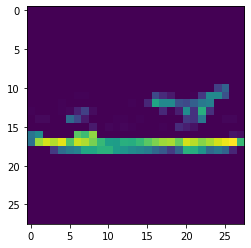

Bag


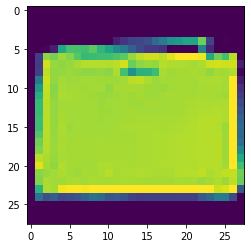

tshirt/top


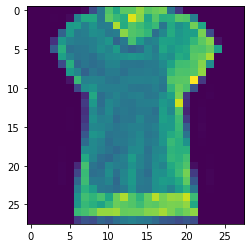

Bag


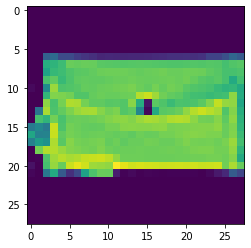

In [225]:
"""
Pruebas visuales para verificar qué tal está el modelo. 
"""

options = ['tshirt/top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle Boot']

for i in range(10):
    number = np.random.randint(1,10000)
    prueba = respuestas[-1][:][:,number]
    print(options[np.argmax(prueba)])
    test = plt.imshow(x_test_ingreso[number].reshape(28,28))
    plt.show()

# Conclusiones 
Se puede verificar en la visualización de los resultados que el modelo ha logrado el objetivo satisfactoriamente. La arquitectura que se utilizó fue la de una fully connected neural network con una hidden layer de 2000 neuronas. Aparte de la división por 1000 que se hizo al inicio con los datos lo más importante para que funcionara el modelo fue experimentar con las inicializaciones de los pesos, lo que resultó más conveniente fue utilizar la función de randn de numpy para generar números aleatorios de una distribución estándar normal y a esos se les dividió por 5. Ese número mágico surgio a prueba y error. <br>
## Acurracy: 83%